In [9]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier

import transforms as t
import classifiers as clsf

np.random.seed(69)

# Data Preprocessing

In [2]:
train_df0 = pd.read_csv('train.csv')
X0_df, Y_c0, Y0 = t.transform_df(train_df0, train=True, as_df=True, k=5)
X0 = X0_df.values
(N, d) = X0.shape

# Model Selection

### Grid Search

In [3]:
### Just gonna take a random 10th for validation
X, valX, Y_c, valY_c, Y, valY = train_test_split(X0, Y_c0, Y0, shuffle=True, test_size=0.1)
pars = t.get_pars_for_processing(X)
X, valX = t.process_with_pars(X, pars), t.process_with_pars(valX, pars)

frac = 1 / 2
t_size, v_size = int(X.shape[0] * frac), int(valX.shape[0] * frac)
train_res, test_res, models = clsf.TuneClassifiers(X[:t_size], valX[:v_size], Y[:t_size], valY[:v_size], algs=['RF'])
test_res

Tuning RF ...
Tuned in: 5.078420877456665
{'max_features': 1, 'min_samples_leaf': 20, 'n_estimators': 50}


,Classifier,Type,Tuning,Accuracy,AUC
1,RF,test,base,0.518581,0.540935
3,RF,test,tuned,0.545608,0.561867


### Save best pars

In [4]:
with open('best_pars.pkl', 'wb') as f:
    pickle.dump({m:model.best_params_ for m, model in models.items()}, f)
    
with open('best_pars.pkl', 'rb') as f:
    best_pars = pickle.load(f)

### Cross Validation

In [5]:
clf = RandomForestClassifier(**models['RF'].best_params_)
aucs, accs = clsf.cross_val(clf, X0, Y_c0, (t.get_pars_for_processing, t.process_with_pars))
aucs.mean(), accs.mean()

CV fold: 3it [00:32, 10.86s/it]


(0.6458523551054406, 0.650074276646747)

### Ensembling

In [ ]:
#from mlxtend.classifier import EnsembleVoteClassifier
#
#model_names = ['test.pkl', 'test2.pkl']
#models = []
#for n in model_names:
#    with open(n, 'rb') as f:
#        models.append(pickle.load(f))
#
#
#clf = EnsembleVoteClassifier(clfs=models,voting="soft",refit=False)      

# Final Fitting

In [6]:
pars = t.get_pars_for_processing(X0)
process = lambda x: t.process_with_pars(x, pars)
clf.fit(process(X0), Y_c0);

### Feature Importances

In [7]:
inds = np.array(sorted(range(len(X0_df.columns)), \
                       key=lambda x: clf.feature_importances_[x], \
                       reverse=True))
imp_dict = dict(zip(X0_df.columns[inds], clf.feature_importances_[inds]))
imp_dict

{'ask_w1': 0.1970215909280676,
 'bid_w1': 0.11571492022548956,
 'last_price': 0.08354207731834676,
 'ask_w5': 0.06863527465670353,
 'bid_w5': 0.06772704733691044,
 'ask_w4': 0.06683019185117113,
 'bid_w4': 0.06594033783587261,
 'ask_w3': 0.06417982890391447,
 'bid_w3': 0.06284820784588849,
 'ask_w2': 0.06145672642440388,
 'bid_w2': 0.061068211069863876,
 'transacted_qty': 0.026165026586788553,
 'closed_position_qty': 0.022250519884601232,
 'd_open_interest': 0.021146070746936398,
 'opened_position_qty ': 0.015473968385041559}

### Save Model

In [10]:
fName = datetime.today().strftime('%y%m%d_%H%M') + "_model.pkl"

with open(fName, 'wb') as f:
    pickle.dump(clf, f)
    
with open(fName, 'rb') as f:
    clf = pickle.load(f)

# Get Predictions on Test Set

In [11]:
test_df0 = pd.read_csv('test.csv')
tX = t.transform_df(test_df0)
tX = process(tX)

output = clf.predict_proba(tX)[:, 1]
     
output_df = pd.DataFrame({'id':test_df0['id'], 'Predicted': output})
output_df.to_csv('submission.csv', index=False)

### Sanity checks on output

mean of train_labels: 0.3569583713157095
mean of train_preds: 0.3821562488923699


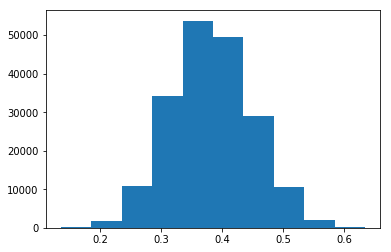

In [12]:
assert(np.all((0 <= output) & (output <= 1)))
print(f'mean of train_labels: {np.mean(Y_c0)}')
print(f'mean of train_preds: {np.mean(output)}')
plt.hist(output);